# Fraud Detection Project

## Previous Notebooks

- [EDA](1-EDA.ipynb)
- [Network Analysis](2.1-Network.ipynb)
- [Lawyers' Network Analysis](2.2-Network-Lawyers.ipynb)
- [Witnesses' Network Analysis](2.3-Network-Witnesses.ipynb)
- [Dataset Creation](3-Input_dataset_creation.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix, accuracy_score, recall_score, precision_score, make_scorer

## Model

In this last notebook I'm going to compare various models to determine whether a claim is fraudolent or not:

- random forest
- random forest without province
- stacking of random forests with different input features
- anomaly detection

In [3]:
X = pd.read_pickle('../data/processed/claims.pkl')

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92245 entries, 2010010000083100 to 2017079430026300
Data columns (total 17 columns):
black_box                   92245 non-null int64
black_box_active            92245 non-null int64
accident_province           92245 non-null object
n_vehicles                  92245 non-null int64
n_people                    92245 non-null int64
card                        92245 non-null int64
injury                      92245 non-null int64
rca                         92245 non-null int64
n_signatures                92245 non-null int64
filing_diff                 92245 non-null int64
filing_month                92245 non-null int64
company_score               92245 non-null float64
score                       92245 non-null float64
lawyer_score                92245 non-null float64
witness_score               92245 non-null float64
total_outgoing_provision    92245 non-null float64
fraud_indicator             92245 non-null int64
dtypes: float64(5), i

In [5]:
le = LabelEncoder()
le.fit(X['accident_province'])
X['accident_province'] = le.transform(X['accident_province'])

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X.drop(['company_score', 'fraud_indicator'], axis=1),
                                                X[['company_score', 'fraud_indicator']],
                                                test_size=0.2,
                                                stratify=X['fraud_indicator'],
                                                random_state=7)

In [7]:
ytrain_score = ytrain['company_score']
ytest_score = ytest['company_score']
ytrain_ind = ytrain['fraud_indicator']
ytest_ind = ytest['fraud_indicator']

In [8]:
kf = StratifiedKFold(n_splits=5, random_state=25)

## Random Forest

In [9]:
rfc = RandomForestClassifier()

In [10]:
param_grid_rfc = {'n_estimators':np.arange(30, 110, 10),
              'max_features':np.arange(1, Xtrain.shape[1]+1, 1),
              'min_samples_split': np.arange(2, 6, 1)}

gs_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc, n_jobs=-1, cv=kf, verbose=10, scoring=make_scorer(f1_score))
gs_rfc.fit(Xtrain, ytrain_ind)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Paralle

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 30,  40,  50,  60,  70,  80,  90, 100]), 'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'min_samples_split': array([2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=10)

In [11]:
print(gs_rfc.best_score_)
print(gs_rfc.best_params_)

0.418412323364
{'max_features': 9, 'min_samples_split': 5, 'n_estimators': 60}


## Random Forest without Province

In [12]:
rfc_noprov = RandomForestClassifier()

In [15]:
param_grid_noprov = {'n_estimators':np.arange(30, 110, 10),
                      'max_features':np.arange(5, Xtrain.shape[1], 1),
                      'min_samples_split': np.arange(2, 6, 1)}

gs_noprov = GridSearchCV(estimator=rfc_noprov, param_grid=param_grid_noprov, n_jobs=2, cv=kf, verbose=10, scoring=make_scorer(f1_score))
gs_noprov.fit(Xtrain.drop(['accident_province'], axis=1), ytrain_ind)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    9.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   16.7s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   27.3s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   43.8s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  4.5min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  6.9min
[Parallel(n_jobs=2)]: Do

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': array([ 30,  40,  50,  60,  70,  80,  90, 100]), 'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_split': array([2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=10)

In [16]:
print(gs_noprov.best_score_)
print(gs_noprov.best_params_)

0.41478661964
{'max_features': 12, 'min_samples_split': 3, 'n_estimators': 30}


## Stacking

For stacking I'm going to further split the data in two separate datasets, one for training three separate random forests with different input features and the other for training a fourth model using the predictions of the first three as features.

In [17]:
Xtrain_lev1, Xtrain_lev2, ytrain_lev1, ytrain_lev2 = train_test_split(Xtrain,
                                                                    ytrain,
                                                                    test_size=0.5,
                                                                    stratify=ytrain['fraud_indicator'],
                                                                    random_state=87)

In [18]:
ytrain_lev1_score = ytrain_lev1['company_score']
ytrain_lev2_score = ytrain_lev2['company_score']
ytrain_lev1_ind = ytrain_lev1['fraud_indicator']
ytrain_lev2_ind = ytrain_lev2['fraud_indicator']

In [19]:
Xtrain_lev1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36898 entries, 2016010401853900 to 2015020530004900
Data columns (total 15 columns):
black_box                   36898 non-null int64
black_box_active            36898 non-null int64
accident_province           36898 non-null int64
n_vehicles                  36898 non-null int64
n_people                    36898 non-null int64
card                        36898 non-null int64
injury                      36898 non-null int64
rca                         36898 non-null int64
n_signatures                36898 non-null int64
filing_diff                 36898 non-null int64
filing_month                36898 non-null int64
score                       36898 non-null float64
lawyer_score                36898 non-null float64
witness_score               36898 non-null float64
total_outgoing_provision    36898 non-null float64
dtypes: float64(4), int64(11)
memory usage: 4.5 MB


In [21]:
Xtrain_rfc1 = Xtrain_lev1[['score', 'card', 'injury', 'rca', 'n_signatures', 'lawyer_score', 'witness_score', 'filing_diff']]
Xtrain_rfc2 = Xtrain_lev1[['score', 'card', 'injury', 'rca', 'n_signatures', 'accident_province', 'black_box', 'black_box_active', 'filing_month']]
Xtrain_rfc3 = Xtrain_lev1[['score', 'card', 'injury', 'rca', 'n_signatures', 'filing_diff', 'total_outgoing_provision', 'n_vehicles','n_people']]

**First Learner**

In [22]:
rfc1 = RandomForestClassifier()

In [23]:
param_grid_l1 = {'n_estimators':np.arange(30, 110, 10),
              'max_features':np.arange(3, Xtrain_rfc1.shape[1]+1, 1),
              'min_samples_split': np.arange(2, 6, 1)}

gs_l1 = GridSearchCV(estimator=rfc1, param_grid=param_grid_l1, n_jobs=-1, cv=kf, verbose=10, scoring=make_scorer(f1_score))
gs_l1.fit(Xtrain_rfc1, ytrain_lev1_ind)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Paralle

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 30,  40,  50,  60,  70,  80,  90, 100]), 'max_features': array([3, 4, 5, 6, 7, 8]), 'min_samples_split': array([2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=10)

In [24]:
print(gs_l1.best_score_)
print(gs_l1.best_params_)

0.384899008854
{'max_features': 5, 'min_samples_split': 3, 'n_estimators': 40}


In [25]:
rfc1.set_params(max_features=5, min_samples_split=3, n_estimators=40)
rfc1.fit(Xtrain_rfc1, ytrain_lev1_ind)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**Second Learner**

In [26]:
rfc2 = RandomForestClassifier()

In [27]:
param_grid_l2 = {'n_estimators':np.arange(30, 110, 10),
              'max_features':np.arange(3, Xtrain_rfc2.shape[1]+1, 1),
              'min_samples_split': np.arange(2, 6, 1)}

gs_l2 = GridSearchCV(estimator=rfc2, param_grid=param_grid_l2, n_jobs=-1, cv=kf, verbose=10, scoring=make_scorer(f1_score))
gs_l2.fit(Xtrain_rfc2, ytrain_lev1_ind)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Paralle

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 30,  40,  50,  60,  70,  80,  90, 100]), 'max_features': array([3, 4, 5, 6, 7, 8, 9]), 'min_samples_split': array([2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=10)

In [28]:
print(gs_l2.best_score_)
print(gs_l2.best_params_)

0.347042255299
{'max_features': 9, 'min_samples_split': 4, 'n_estimators': 80}


In [29]:
rfc2.set_params(max_features=9, min_samples_split=4, n_estimators=80)
rfc2.fit(Xtrain_rfc2, ytrain_lev1_ind)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**Third Learner**

In [30]:
rfc3 = RandomForestClassifier()

In [31]:
param_grid_l3 = {'n_estimators':np.arange(30, 110, 10),
              'max_features':np.arange(3, Xtrain_rfc3.shape[1]+1, 1),
              'min_samples_split': np.arange(2, 6, 1)}

gs_l3 = GridSearchCV(estimator=rfc3, param_grid=param_grid_l3, n_jobs=-1, cv=kf, verbose=10, scoring=make_scorer(f1_score))
gs_l3.fit(Xtrain_rfc3, ytrain_lev1_ind)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Paralle

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 30,  40,  50,  60,  70,  80,  90, 100]), 'max_features': array([3, 4, 5, 6, 7, 8, 9]), 'min_samples_split': array([2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=10)

In [32]:
print(gs_l3.best_score_)
print(gs_l3.best_params_)

0.371627560344
{'max_features': 3, 'min_samples_split': 5, 'n_estimators': 30}


In [33]:
rfc3.set_params(max_features=3, min_samples_split=5, n_estimators=30)
rfc3.fit(Xtrain_rfc3, ytrain_lev1_ind)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**Stacking**

Here I'm going to use the predictions from the three learners to train a logistic regression model and come up with the final prediction.

In [36]:
Xtrain_lev2_rfc1 = Xtrain_lev2[['score', 'card', 'injury', 'rca', 'n_signatures', 'lawyer_score', 'witness_score', 'filing_diff']]
Xtrain_lev2_rfc2 = Xtrain_lev2[['score', 'card', 'injury', 'rca', 'n_signatures', 'accident_province', 'black_box', 'black_box_active', 'filing_month']]
Xtrain_lev2_rfc3 = Xtrain_lev2[['score', 'card', 'injury', 'rca', 'n_signatures', 'filing_diff', 'total_outgoing_provision', 'n_vehicles','n_people']]

In [37]:
ypred_rfc1 = rfc1.predict_proba(Xtrain_lev2_rfc1)
ypred_rfc2 = rfc2.predict_proba(Xtrain_lev2_rfc2)
ypred_rfc3 = rfc3.predict_proba(Xtrain_lev2_rfc3)

In [38]:
Xtrain_stack = pd.DataFrame(np.vstack([ypred_rfc1[:, 1], ypred_rfc2[:, 1], ypred_rfc3[:, 1]]).T,
                            index=Xtrain_lev2.index,
                            columns=['rfc1', 'rfc2', 'rfc3'])
Xtrain_stack.head()

,rfc1,rfc2,rfc3
claim_code,,,
2016030400394300,0.0,0.0,0.0
2016010402002500,0.0,0.0,0.0
2015010401768000,0.0,0.0,0.0
2015030430066300,0.0,0.0,0.0
2016010430003800,0.0,0.0,0.0


In [39]:
lr = LogisticRegression()

In [40]:
param_grid_lr = {'C':[1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1, 3, 1e1, 3e1, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4]}

gs_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, n_jobs=-1, cv=5, verbose=10, scoring=make_scorer(f1_score))
gs_lr.fit(Xtrain_stack, ytrain_lev2_ind)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=10)

In [41]:
print(gs_lr.best_score_)
print(gs_lr.best_params_)

0.384642727923
{'C': 100.0}


## Anomaly Detection

Finally, I'm going to try to use two anomaly detection algorithms to try and predict frauds. The models I try are KMeans clustering for anomaly detection (I consider anomalous the points far away from cluster centers) and Local Outlier Factor, a density-based algorithm in which points in sparser areas than their neighbours are considered outliers.

For both of this algorithms it is best to scale the data; moreover in order to be able to compare their results with the previous ones I will implement k-fold cross-validation by hand.

In [42]:
sc = StandardScaler()
Xtrainsc = sc.fit_transform(Xtrain.drop('accident_province', axis=1))

**KMeans**

In [43]:
param_grid_km = {'n_clust':np.arange(2, 11, 1),
              'n_std':np.arange(2, 4.25, 0.25)}

In [44]:
scores_km = {}
for n_clust in param_grid_km['n_clust']:
    curr_scores = []
    for n_std in param_grid_km['n_std']:
        for train_idx, val_idx in kf.split(Xtrainsc, ytrain_ind):
            Xtr_fold = Xtrainsc[train_idx]
            Xval_fold = Xtrainsc[val_idx]
            ytr_fold = ytrain_ind.iloc[train_idx]
            yval_fold = ytrain_ind.iloc[val_idx]

            km = KMeans(n_clusters=n_clust)
            km.fit(Xtr_fold)

            distances = km.transform(Xval_fold)
            labels = km.predict(Xval_fold)
            distances = np.array([distances[i, labels[i]] for i in range(len(labels))])

            centroid_median_dist = np.zeros(n_clust)
            centroid_std_dist = np.zeros(n_clust)
            for i in range(n_clust):
                centroid_median_dist[i] = np.median(distances[labels==i])
                centroid_std_dist[i] = np.std(distances[labels==i])

            yval_pred = np.abs(distances - centroid_median_dist[labels]) > n_std*centroid_std_dist[labels]
            curr_scores.append(f1_score(yval_fold, yval_pred))
    
        scores_km['n_clust={}, n_std={}'.format(n_clust, n_std)] = np.mean(curr_scores)

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [45]:
best_params_km = ''
best_score_km = 0
for key in scores_km:
    if scores_km[key] > best_score_km:
        best_score_km = scores_km[key]
        best_params_km = key

best_params_km, best_score_km

('n_clust=5, n_std=2.0', 0.11025358411772934)

**Local Outlier Factor**

In [46]:
param_grid_lof = {'n_neigh':np.arange(2, 11, 1),
              'contamination':np.arange(0.01, 0.055, 0.005)}

In [47]:
n_jobs = -1
scores_lof = {}
for n_neigh in param_grid_lof['n_neigh']:
    curr_scores = []
    for contamination in param_grid_lof['contamination']:
        for train_idx, val_idx in kf.split(Xtrainsc, ytrain_ind):
            Xtr_fold = Xtrainsc[train_idx]
            Xval_fold = Xtrainsc[val_idx]
            ytr_fold = ytrain_ind.iloc[train_idx]
            yval_fold = ytrain_ind.iloc[val_idx]

            lof = LocalOutlierFactor(n_neighbors=n_neigh, contamination=contamination, n_jobs=n_jobs)
            lof.fit(Xtr_fold)

            yval_pred = lof.fit_predict(Xval_fold)
            yval_pred = np.array((yval_pred - 1) / -2, dtype=int)
            curr_scores.append(f1_score(yval_fold, yval_pred))
    
        scores_lof['n_neigh={}, contamination={}'.format(n_neigh, contamination)] = np.mean(curr_scores)

In [48]:
best_params_lof = ''
best_score_lof = 0
for key in scores_lof:
    if scores_lof[key] > best_score_lof:
        best_score_lof = scores_lof[key]
        best_params_lof = key

best_params_lof, best_score_lof

('n_neigh=2, contamination=0.01', 0.0017937219730941704)

## And the Winner Is...

The anomaly detection models are clearly underperforming, and while I may try to tweak a little the stacked random forests to get a better result I don't think the added complexity is worth it.

This leaves me with the first two random forests, and since the cross-validation score is quite similar I'm going with the model without province data to avoid the possibility of bias, as I mentioned before.

In [49]:
rfc_noprov.set_params(max_features=12, min_samples_split=3, n_estimators=30)
rfc_noprov.fit(Xtrain, ytrain_ind)
ypred = rfc_noprov.predict(Xtrain)
ypred_proba = rfc_noprov.predict_proba(Xtrain)

I'm glad to see that the scores computed from the various networks are quite important in the model:

In [52]:
for imp, col in sorted(zip(rfc_noprov.feature_importances_, Xtrain.columns), reverse=True):
    print('{} importance: {:.5f}'.format(col, imp))

filing_diff importance: 0.24020
score importance: 0.20638
lawyer_score importance: 0.15382
filing_month importance: 0.08169
total_outgoing_provision importance: 0.06989
witness_score importance: 0.05275
accident_province importance: 0.05175
n_signatures importance: 0.02699
n_vehicles importance: 0.02344
black_box_active importance: 0.02176
n_people importance: 0.02073
card importance: 0.01767
rca importance: 0.01444
black_box importance: 0.01242
injury importance: 0.00608


The model has a pretty high accuracy (as expected, since the target variable is very skewed) and a good precision. The recall score is not very high and the F1 score is close sufficiently close to 0.5, which is not great but neither that bad considering the difficulty of the task.

In [54]:
ypred_ts = rfc_noprov.predict(Xtest)
ypred_ts_proba = rfc_noprov.predict_proba(Xtest)
print('Accuracy: {}'.format(accuracy_score(ytest_ind, ypred_ts)))
print('Recall: {}'.format(recall_score(ytest_ind, ypred_ts)))
print('Precision: {}'.format(precision_score(ytest_ind, ypred_ts)))
print('F1: {}'.format(f1_score(ytest_ind, ypred_ts)))

Accuracy: 0.9840099734402948
Recall: 0.3548387096774194
Precision: 0.7058823529411765
F1: 0.47227191413237923


Let's also take a look at the confusion matrix and precision-recall curve:

In [55]:
pd.DataFrame(confusion_matrix(ytest_ind, ypred_ts), index=['y=0', 'y=1'], columns=['pred=0', 'pred=1'])

,pred=0,pred=1
y=0,18022,55
y=1,240,132


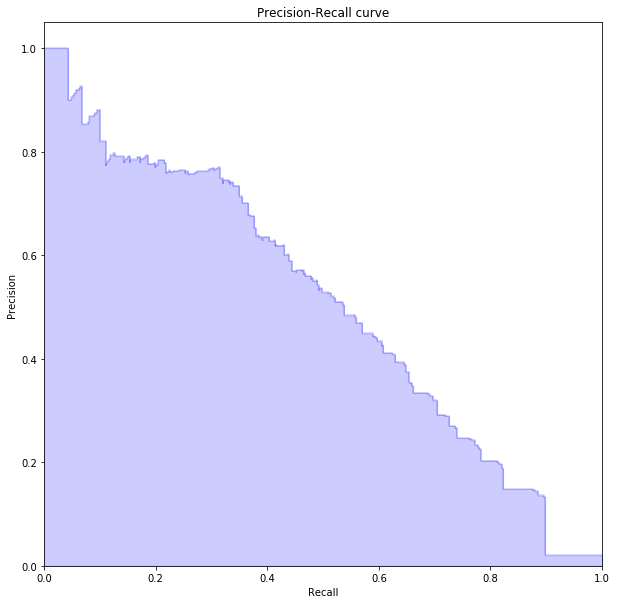

In [56]:
precision, recall, thresholds = precision_recall_curve(ytest_ind, [prob[1] for prob in ypred_ts_proba])

plt.figure(figsize=(10, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve');
# plt.savefig('../reports/figures/precision_recall.png');

I could try to tweak a little the threshold value to get a better recall score, but I won't try it now.

Instead I want to look closely at the false positives and negatives and see how they compare to the fraud evaluation, which is something more precise than the score since it involves some official investigation of the claim.

In [57]:
assessments = pd.read_csv('../data/raw/antifraud_assessments.csv', sep=';')

These are the false negatives, among them there are 51 proven frauds (`Frode acclarata`), but also 20 claims which were proven *not* fraudolent (`Nessuna frode`).

In [58]:
pd.DataFrame(assessments.loc[(assessments['claim_code'].isin(Xtest.iloc[ypred_ts==0].index)) & (assessments['company_score']>50), 'fraud_evaluation'].value_counts())

,fraud_evaluation
Frode probabile,84
Frode acclarata,51
Nessuna frode,20


Among the false positives instead I have 8 proven frauds and only 4 non-frauds.

In [59]:
pd.DataFrame(assessments.loc[(assessments['claim_code'].isin(Xtest.iloc[ypred_ts==1].index)) & (assessments['company_score']<=50), 'fraud_evaluation'].value_counts())

,fraud_evaluation
Frode probabile,8
Frode acclarata,8
Nessuna frode,4


## Conclusions

In this project I tried to predict whether a claim is fraudolent analyzing network-like data obtained from the involvement of parties in claims. I learned a lot about graphs and rankings on them and I had fun trying out different techniques to label the claims, such as stacking and anomaly detection.

While the final F1 score of 0.47 isn't great I'm quite happy with it, given the difficulty of the task at hand; also, by looking at the false positives' and negatives' fraud evaluations, I found out that even if my score isn't perfect the same holds true for the company score, since some claims are mislabeled in both ways.

I think this score may be useful for the insurance company, if anything because it can give them another way to find fraudolent claims or suggest new directions to investigate. In addition I think this score may be of help to the people assessing frauds and could spare them some manual work, namely the research into parties involved in the claim.

## Further Analysis

Things I could have tried if I had more time:

- Find some absolute ground truth, since the score I used as a target variable is a company score, so it is obviously biased.
- Try some other values for the threshold of my model and compare how false positives and negatives behave.
- Find out if it is possible to get network-like data for all the claims in Italy, since using only data from one company makes my network incomplete.